In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def prepare_data(df: pd.DataFrame, target_col: str):
    """
    Split features and target, then create train/test sets.
    """
    features = [
        'Global_active_power', 'Global_intensity',
        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
        'hour', 'day_of_week', 'month'
    ]
    X = df[features]
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    
    return X_train, X_test, y_train, y_test

def evaluate_model(model, X_test, y_test):
    """
    Print evaluation metrics for regression model.
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    return rmse, r2

def train_linear_regression(X_train, y_train):
    """
    Train a Linear Regression model in a pipeline with scaling.
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    pipeline.fit(X_train, y_train)
    return pipeline

def train_random_forest(X_train, y_train):
    """
    Train a Random Forest model.
    """
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model



In [2]:
from pathlib import Path
import os
PROJECT_ROOT = Path("02_model_training.ipynb").resolve().parents[1]
data_path = os.path.join(PROJECT_ROOT, "data/processed_data.csv")
df = pd.read_csv(data_path)
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_total,Apparent_power,...,Global_intensity_lag1,Global_active_power_lag5,Global_reactive_power_lag5,Global_intensity_lag5,Global_active_power_lag10,Global_reactive_power_lag10,Global_intensity_lag10,Global_active_power_lag15,Global_reactive_power_lag15,Global_intensity_lag15
0,2010-06-06 03:13:00,0.246,0.076,242.49,1.0,0.0,0.0,1.0,1.0,0.242490,...,1.0,0.246,0.076,1.0,0.246,0.076,1.0,0.246,0.076,1.0
1,2008-06-15 12:56:00,3.880,0.398,235.81,16.4,38.0,3.0,18.0,59.0,3.867284,...,1.0,0.246,0.076,1.0,0.246,0.076,1.0,0.246,0.076,1.0
2,2008-05-29 13:25:00,0.162,0.000,235.54,0.6,0.0,0.0,1.0,1.0,0.141324,...,16.4,0.246,0.076,1.0,0.246,0.076,1.0,0.246,0.076,1.0
3,2009-01-16 07:43:00,2.480,0.000,239.86,10.2,0.0,0.0,17.0,17.0,2.446572,...,0.6,0.246,0.076,1.0,0.246,0.076,1.0,0.246,0.076,1.0
4,2010-11-03 07:21:00,0.360,0.120,244.47,1.6,0.0,0.0,1.0,1.0,0.391152,...,10.2,0.246,0.076,1.0,0.246,0.076,1.0,0.246,0.076,1.0


In [3]:
# 1️⃣ Predict Reactive Power
print("\n--- Predicting Global Reactive Power ---")
X_train, X_test, y_train, y_test = prepare_data(df, 'Global_reactive_power')
    
lin_model = train_linear_regression(X_train, y_train)
rf_model = train_random_forest(X_train, y_train)
    
print("\nLinear Regression Results:")
evaluate_model(lin_model, X_test, y_test)

print("\nRandom Forest Results:")
evaluate_model(rf_model, X_test, y_test)

# 2️⃣ Predict Voltage (optional)
print("\n--- Predicting Voltage ---")
X_train_v, X_test_v, y_train_v, y_test_v = prepare_data(df, 'Voltage')
    
rf_model_v = train_random_forest(X_train_v, y_train_v)
evaluate_model(rf_model_v, X_test_v, y_test_v)


--- Predicting Global Reactive Power ---

Linear Regression Results:
RMSE: 0.0972
R²: 0.2347

Random Forest Results:
RMSE: 0.0751
R²: 0.5426

--- Predicting Voltage ---
RMSE: 2.0319
R²: 0.6134


(np.float64(2.031895236650013), 0.6134039078435427)

In [4]:
# ===========================
# Neural Network Regressor
# ===========================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1- Dataset preparation
# ---------------------------

class PowerDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, scaler=None, fit_scaler=True):
        X = df[feature_cols].values.astype(np.float32)
        y = df[target_col].values.astype(np.float32).reshape(-1, 1)

        if scaler is None:
            scaler = StandardScaler()
            if fit_scaler:
                X = scaler.fit_transform(X)
        else:
            X = scaler.transform(X)

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.scaler = scaler

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

    

In [5]:
# ---------------------------
# 2- Model definition
# ---------------------------

class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# ---------------------------
# 3- Train / Eval utilities
# ---------------------------

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    return running_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_all, y_all = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            running_loss += loss.item() * X.size(0)
            preds_all.append(preds.cpu().numpy())
            y_all.append(y.cpu().numpy())

    preds_all = np.vstack(preds_all)
    y_all = np.vstack(y_all)
    mse = mean_squared_error(y_all, preds_all)
    mae = mean_absolute_error(y_all, preds_all)
    r2 = r2_score(y_all, preds_all)
    return running_loss / len(dataloader.dataset), mse, mae, r2

In [8]:
# ---------------------------
# 4- Training procedure
# ---------------------------

# Example target
target_col = "Global_reactive_power"

# Feature columns — everything except target and datetime
all_cols = ['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Sub_total', 'Apparent_power', 'Power_factor',
       'month', 'hour', 'day_of_week', 'Global_active_power_lag1',
       'Global_reactive_power_lag1', 'Global_intensity_lag1',
       'Global_active_power_lag5', 'Global_reactive_power_lag5',
       'Global_intensity_lag5', 'Global_active_power_lag10',
       'Global_reactive_power_lag10', 'Global_intensity_lag10',
       'Global_active_power_lag15', 'Global_reactive_power_lag15',
       'Global_intensity_lag15']

exclude_cols = ['datetime', 'Voltage', 'Global_active_power_lag1',
       'Global_reactive_power_lag1', 'Global_intensity_lag1',
       'Global_active_power_lag5', 'Global_reactive_power_lag5',
       'Global_intensity_lag5', 'Global_active_power_lag10',
       'Global_reactive_power_lag10', 'Global_intensity_lag10',
       'Global_active_power_lag15', 'Global_reactive_power_lag15',
       'Global_intensity_lag15', target_col]

feature_cols = [c for c in df.columns if c not in exclude_cols]

# Create dataset
full_dataset = PowerDataset(df, feature_cols, target_col)
scaler = full_dataset.scaler

# Split into train / test (80-20)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, optimizer, loss
model = MLPRegressor(input_dim=len(feature_cols)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
n_epochs = 25
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, mse, mae, r2 = eval_epoch(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1:02d}/{n_epochs} | Train Loss: {train_loss:.4f} | Val RMSE: {np.sqrt(mse):.4f} | R²: {r2:.4f}")


Using device: cpu
Epoch 01/25 | Train Loss: 0.0098 | Val RMSE: 0.0871 | R²: 0.4046
Epoch 02/25 | Train Loss: 0.0073 | Val RMSE: 0.0840 | R²: 0.4460
Epoch 03/25 | Train Loss: 0.0070 | Val RMSE: 0.0848 | R²: 0.4357
Epoch 04/25 | Train Loss: 0.0067 | Val RMSE: 0.0817 | R²: 0.4761
Epoch 05/25 | Train Loss: 0.0065 | Val RMSE: 0.0822 | R²: 0.4698
Epoch 06/25 | Train Loss: 0.0063 | Val RMSE: 0.0795 | R²: 0.5038
Epoch 07/25 | Train Loss: 0.0062 | Val RMSE: 0.0793 | R²: 0.5065
Epoch 08/25 | Train Loss: 0.0062 | Val RMSE: 0.0789 | R²: 0.5119
Epoch 09/25 | Train Loss: 0.0060 | Val RMSE: 0.0793 | R²: 0.5062
Epoch 10/25 | Train Loss: 0.0059 | Val RMSE: 0.0785 | R²: 0.5168
Epoch 11/25 | Train Loss: 0.0059 | Val RMSE: 0.0778 | R²: 0.5256
Epoch 12/25 | Train Loss: 0.0058 | Val RMSE: 0.0774 | R²: 0.5294
Epoch 13/25 | Train Loss: 0.0058 | Val RMSE: 0.0780 | R²: 0.5226
Epoch 14/25 | Train Loss: 0.0058 | Val RMSE: 0.0768 | R²: 0.5371
Epoch 15/25 | Train Loss: 0.0057 | Val RMSE: 0.0774 | R²: 0.5305
Epoch 1

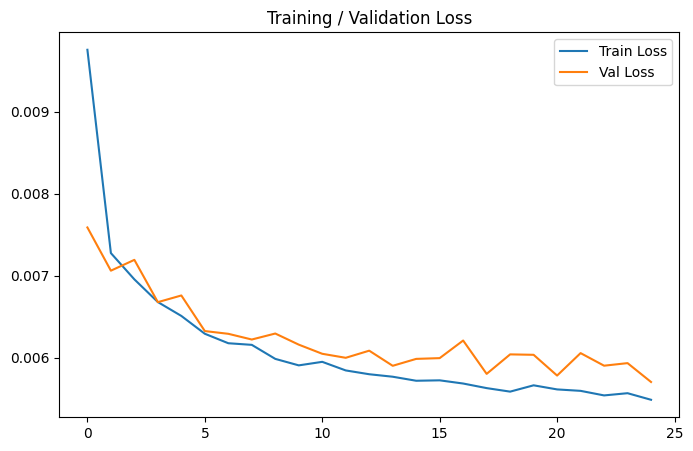


Final Evaluation:
  RMSE = 0.0755
  MAE = 0.0545
  R² = 0.5526


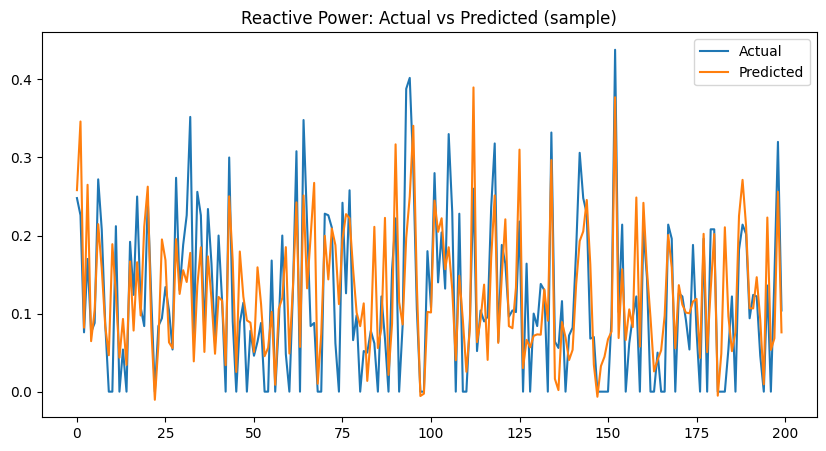

In [9]:
# Plot training curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training / Validation Loss")
plt.legend()
plt.show()

# Final metrics
val_loss, mse, mae, r2 = eval_epoch(model, test_loader, criterion, device)
print(f"\nFinal Evaluation:\n  RMSE = {np.sqrt(mse):.4f}\n  MAE = {mae:.4f}\n  R² = {r2:.4f}")

# Example: visualize a subset of predictions vs actuals
model.eval()
X_batch, y_batch = next(iter(test_loader))
with torch.no_grad():
    preds = model(X_batch.to(device)).cpu().numpy()

plt.figure(figsize=(10,5))
plt.plot(y_batch.numpy()[:200], label='Actual')
plt.plot(preds[:200], label='Predicted')
plt.title("Reactive Power: Actual vs Predicted (sample)")
plt.legend()
plt.show()